In [57]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import bounded_alphas, costs, model, weighted_costs, weighted_bounded_alphas

running model
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask]
    test_mask = (data.index > "2011")
    test = data[test_mask]
    return train, test

In [59]:
all_weather = pd.read_csv("weather01-16.csv")

In [60]:
cm_weather = all_weather[all_weather.stn_name == "Chiang Mai"]
cm_weather.index = pd.DatetimeIndex(cm_weather.date)
mask = (cm_weather.index > "2003") & (cm_weather.index < "2016")
cm_weather = cm_weather[mask]

provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)
cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])

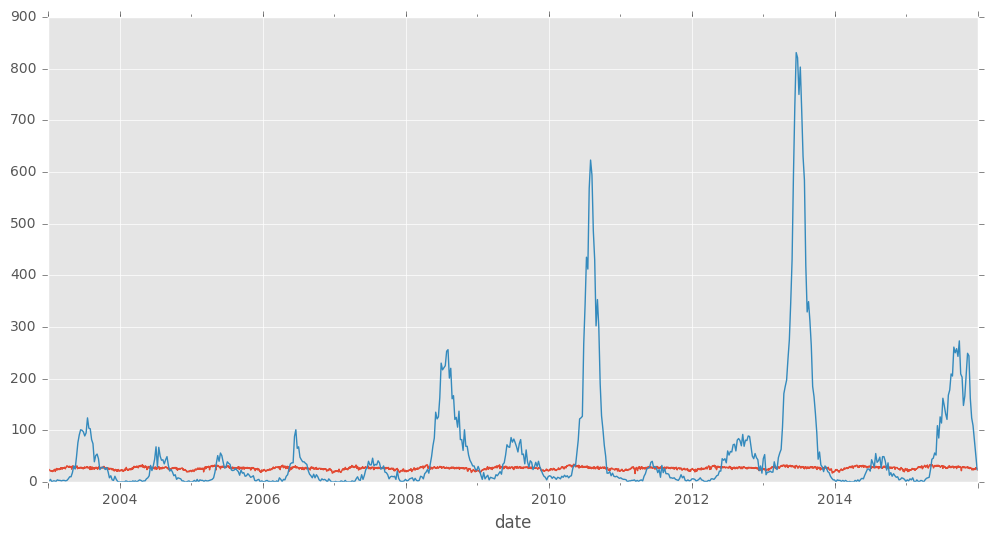

In [61]:
plt.figure(figsize=(12,6))
cm_weather.meantemp.plot()
cm_dengues_df.cases[:-52].plot()

In [62]:
# cm_weather.tail()

In [63]:
cm_avg_weather = cm_weather[['avgrh','dday','maxtemp','meantemp','mintemp','rain']].resample('W').mean()


In [64]:
cm_dengues_weather = pd.concat([cm_avg_weather,cm_dengues_df[:-52]],axis=1)

In [65]:
cm_dengues_weather

,avgrh,dday,maxtemp,meantemp,mintemp,rain,cases
date,,,,,,,
2003-01-05,88.250000,3.500000,26.300000,23.500000,20.750000,3.050000,1
2003-01-12,81.000000,9.000000,27.942857,22.828571,17.757143,0.000000,2
2003-01-19,80.714286,16.000000,27.514286,21.457143,15.400000,0.000000,5
2003-01-26,75.857143,23.000000,27.728571,20.671429,13.700000,0.000000,0
2003-02-02,75.857143,21.142857,29.842857,22.628571,15.500000,0.000000,2
2003-02-09,74.857143,6.000000,28.842857,22.728571,16.685714,0.000000,2
2003-02-16,70.857143,13.000000,32.457143,24.957143,17.514286,0.000000,1
2003-02-23,62.857143,20.000000,32.885714,24.200000,15.585714,0.000000,4
2003-03-02,57.857143,19.000000,34.200000,24.457143,14.742857,0.000000,3


In [70]:
cm_dengues_weather_split = split_data(cm_dengues_weather)
cm_dengues_train, cm_dengues_test = cm_dengues_weather_split[0], cm_dengues_weather_split[1]

running model


In [14]:
cm_dengues_train.tail()

,avgrh,dday,maxtemp,meantemp,mintemp,rain,cases
date,,,,,,,
2010-11-28,73.428571,25.000000,31.371429,25.100000,20.300000,0.000000,17
2010-12-05,73.142857,10.571429,30.185714,23.914286,18.785714,0.000000,11
2010-12-12,74.428571,9.000000,30.628571,24.828571,20.328571,0.057143,10
2010-12-19,76.428571,16.000000,28.100000,23.614286,20.185714,0.814286,11
2010-12-26,73.285714,23.000000,30.757143,23.457143,17.842857,0.000000,9


In [66]:
%%time

def cost(w):
    
    ret = 0
    for i in range(len(cm_dengues_train)-27):
#         real_case = cm_dengues_df[:-52].cases[i+1]
        cases_for_prediction = cm_dengues_train.cases[i:i+26]
        nth_week = i + 27
        degree = cm_dengues_train.meantemp[i]
                                #guess(w, nth_week, cases_for_prediction, degree)
        predicted_case = model.guess(
            w,
            nth_week,
            cases_for_prediction,
            degree)
        real_case = cm_dengues_train.cases[i+27] + 1
        sigma_sq = real_case + 1
        
        ret += ((real_case - predicted_case)**2)/float(sigma_sq)
    return ret

arr = [1.]*31
w = minimize(cost,arr)

CPU times: user 9min 45s, sys: 1.47 s, total: 9min 47s
Wall time: 9min 48s


In [67]:
w.x

array([  7.42103809e+00,   6.86782416e-01,   6.61705956e-01,
         1.72090672e+00,  -3.90263825e-02,   4.36393841e-01,
         1.18947360e+00,   4.38743332e-01,   3.95801856e-01,
         9.30275051e-01,   2.16150957e-01,  -4.51650525e-02,
        -8.63593494e-01,  -1.22916211e+00,  -4.18555922e-01,
        -4.02183695e-01,  -1.93989017e-01,  -4.50663941e-01,
        -1.65394997e-01,  -7.74489960e-01,  -2.03345531e+00,
        -2.64010703e+00,  -5.86131252e+00,  -3.87893021e+00,
        -1.17453783e+01,  -9.90272963e+00,   6.13262501e+01,
         1.40694603e+00,  -8.85505103e+00,  -1.10148130e-05,
         3.74224318e-04])

In [176]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "%s's Dengue Prediction"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(cm_dengues_df.cases,cm_dengues_train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
#     plt.savefig("13-lags-14-weeks-weather-chiangmai.png")
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

In [172]:
predictions = []
for i in range(len(cm_dengues_weather)-27):
    predicted = model.guess(
        w.x,
        i+27,
        cm_dengues_weather.cases[i:i+26],
        cm_dengues_weather.meantemp[i])
    predictions.append(predicted)

# plt.figure(figsize=(12,6))
# plt.plot(range(26,len(predictions)+26),predictions,label="prediction")
# plt.plot(range(len(cm_dengues_weather)),cm_dengues_weather.cases)
# plt.legend()

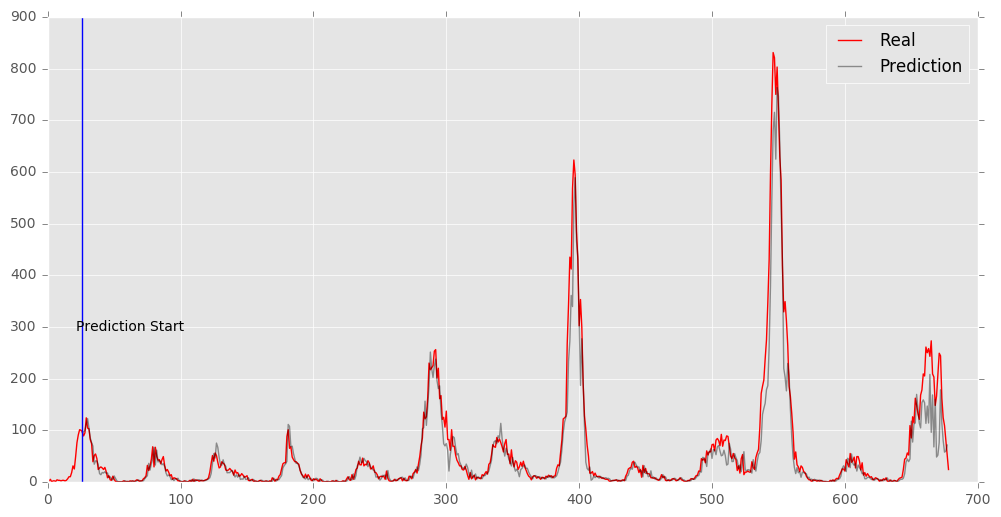

In [177]:
make_line(26,cm_dengues_weather.cases,predictions,"","","")

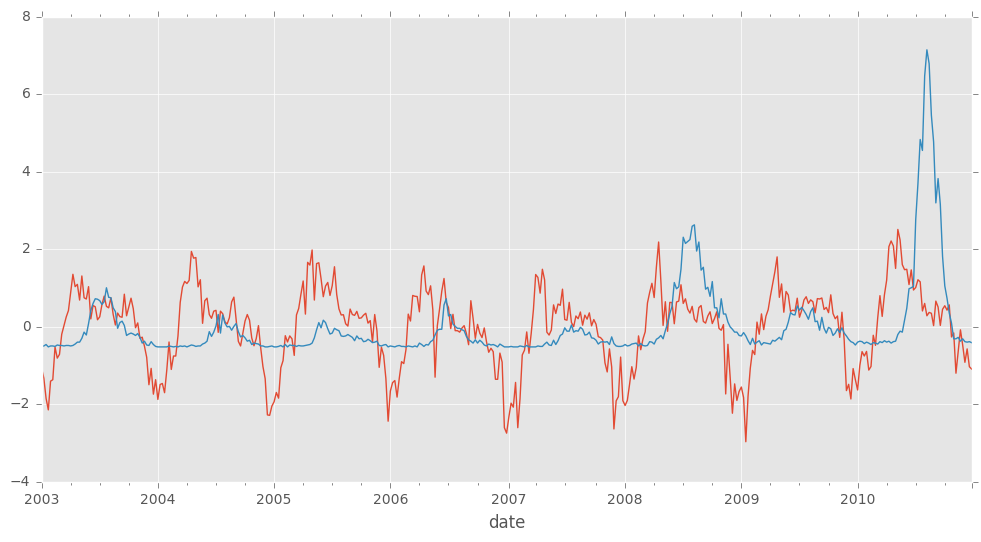

In [83]:
plt.figure(figsize=(12,6))
((cm_dengues_train.meantemp - cm_dengues_train.meantemp.mean())/cm_dengues_train.meantemp.std()).plot()
((cm_dengues_train.cases-cm_dengues_train.cases.mean())/cm_dengues_train.cases.std()).plot()

In [113]:
yr = [str(i) for i in range(2003,2012)]
tmp = []
for i in range(len(yr)-1):
    mask = (cm_dengues_train.index > yr[i]) & (cm_dengues_train.index < yr[i+1])
    tmp.append(cm_dengues_train[mask])

In [164]:
train_weekly_cases = []
train_weekly_meantemp = []
train_weekly_rain = []
train_weekly_avgrh = []
for data in tmp:
    train_weekly_cases.append(data.cases)
    train_weekly_meantemp.append(data.meantemp)
    train_weekly_rain.append(data.rain)
    train_weekly_avgrh.append(data.avgrh)

In [165]:
train_weekly_cases = np.array(train_weekly_cases)
train_weekly_meantemp = np.array(train_weekly_meantemp)
train_weekly_rain = np.array(train_weekly_rain)
train_weekly_avgrh = np.array(train_weekly_avgrh)

In [166]:
avg_train_weekly_cases = sum(train_weekly_cases) / 8.
norm_train_weekly_cases = pd.Series((avg_train_weekly_cases - avg_train_weekly_cases.mean())/avg_train_weekly_cases.std())

avg_train_weekly_meantemp = sum(train_weekly_meantemp) / 8.
norm_train_weekly_meantemp = pd.Series((avg_train_weekly_meantemp - avg_train_weekly_meantemp.mean())/avg_train_weekly_meantemp.std())

avg_train_weekly_rain = sum(train_weekly_rain) / 8.
norm_train_weekly_rain = pd.Series((avg_train_weekly_rain - avg_train_weekly_rain.mean())/avg_train_weekly_rain.std())

avg_train_weekly_avgrh = sum(train_weekly_avgrh) / 8.
norm_train_weekly_avgrh = pd.Series((avg_train_weekly_avgrh - avg_train_weekly_avgrh.mean())/avg_train_weekly_avgrh.std())

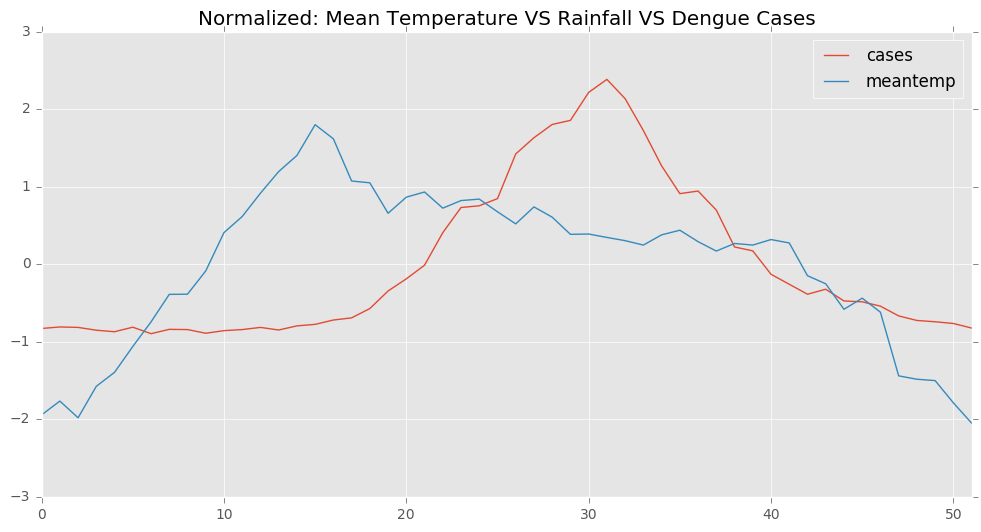

In [169]:
plt.figure(figsize=(12,6))
plt.plot(norm_train_weekly_cases,label='cases')
plt.plot(norm_train_weekly_meantemp,label='meantemp')
# plt.plot(norm_train_weekly_rain,label='rain')
# plt.plot(norm_train_weekly_avgrh,label='avgrh')
plt.xlim(0,51)
plt.title("Normalized: Mean Temperature VS Rainfall VS Dengue Cases")
plt.legend()